In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.datasets import fetch_openml
from scipy import io
from tqdm import tqdm
from google.colab import drive

drive.mount('./gdrive', force_remount=True)
plt.style.use("seaborn")
plt.rc('font', family='NanumBarunGothic')
plt.rc('axes', unicode_minus=False)
warnings.filterwarnings(action='ignore')

Mounted at ./gdrive


In [34]:
mnist = io.loadmat('/content/gdrive/MyDrive/Colab Notebooks/투빅스/pca/mnist-original.mat')
X = mnist['data'].T
y = mnist['label'].T

In [35]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [36]:
y

array([[0.],
       [0.],
       [0.],
       ...,
       [9.],
       [9.],
       [9.]])

In [37]:
# data를 각 픽셀에 이름붙여 표현
feat_cols = [ 'pixel'+str(i) for i in range(X.shape[1]) ]
df = pd.DataFrame(X,columns=feat_cols)
df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [38]:
# df에 label y를 붙여 데이터 프레임 생성
df['y'] = y
print('Size of the dataframe: {}'.format(df.shape))

Size of the dataframe: (70000, 785)


<Figure size 432x288 with 0 Axes>

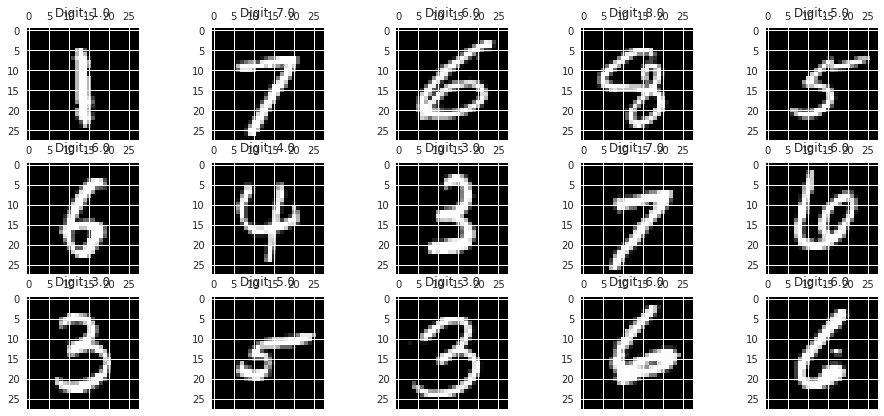

In [39]:
# 데이터 형태 시각화

rndperm = np.random.permutation(df.shape[0])

# Plot the graph
plt.gray()
fig = plt.figure( figsize=(16,7) )
for i in range(0,15):
    ax = fig.add_subplot(3,5,i+1, title="Digit: {}".format(str(df.loc[rndperm[i],'y'])) )
    ax.matshow(df.loc[rndperm[i],feat_cols].values.reshape((28,28)).astype(float))
plt.show()

# 1) train_test_split을 통해 데이터를 8:2로 분할

In [40]:
from sklearn.model_selection import train_test_split

train_data, test_data, label, y_test = train_test_split(df.iloc[:, :-1], df['y'], test_size = 0.2, random_state = 42)

In [41]:
print(train_data.shape)
print(test_data.shape)
print(label.shape)
print(y_test.shape)

(56000, 784)
(14000, 784)
(56000,)
(14000,)


# 2) PCA & LDA

차원축소 전 데이터 scaling

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

### pca

#### elbow point (n_components에 따른 분산의 설명량 곡선에서 곡선의 기울기가 급격히 감소하는 지점)

In [11]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(train_data)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

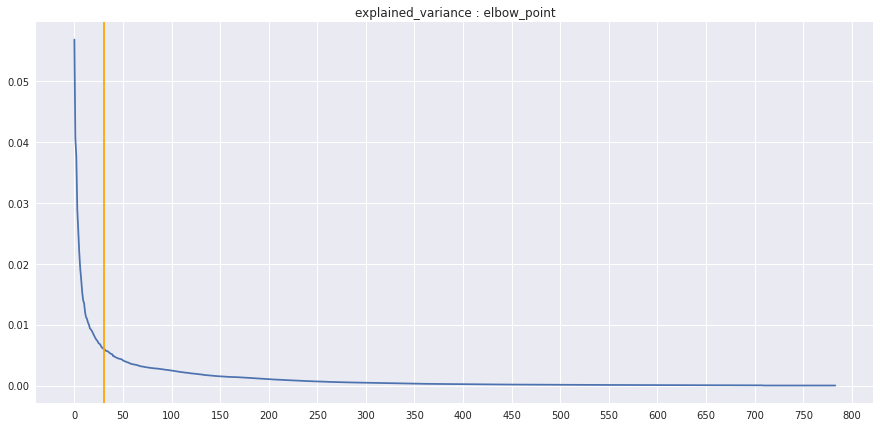

In [12]:
plt.figure(figsize = (15, 7))
plt.plot(pca.explained_variance_ratio_)
plt.xticks([50 * i for i in range(0, 17)])
plt.title("explained_variance : elbow_point")
plt.axvline(30, color = 'orange')
plt.show()

30 근처에서 급격히 꺾이는 것으로 보이나 더 세밀하게 elbow point를 확인하기 위해 1~50구간만 확인

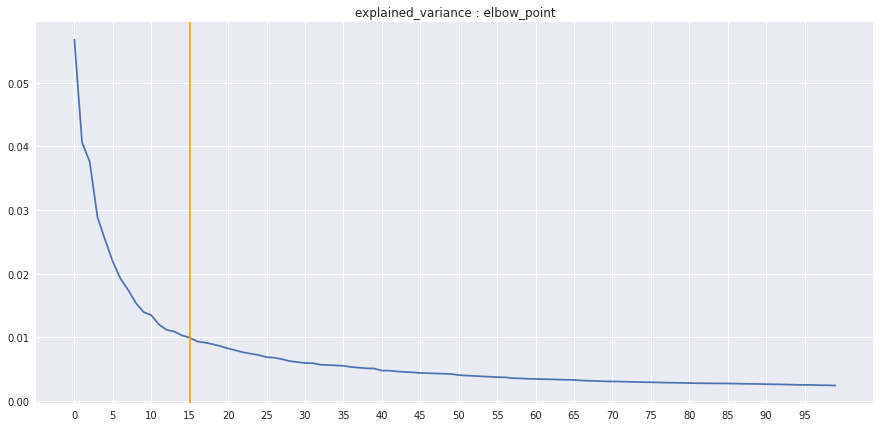

In [13]:
plt.figure(figsize = (15, 7))
plt.plot(pca.explained_variance_ratio_[:100])
plt.xticks([5 * i for i in range(20)])
plt.title("explained_variance : elbow_point")
plt.axvline(15, color = 'orange')
plt.show()

약 15개 이후의 주성분 설명량은 미미해보임

#### kaiser's rule ( 고유값 1 이상)

In [14]:
n_kaiser = len(pca.explained_variance_[pca.explained_variance_ >= 1])
kaiser_rule = pca.explained_variance_[pca.explained_variance_ >= 1]

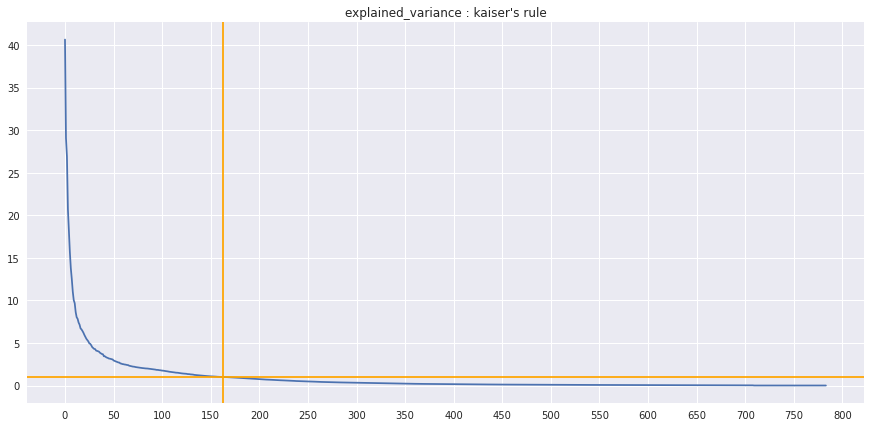

In [15]:
plt.figure(figsize = (15, 7))
plt.plot(pca.explained_variance_)
plt.xticks([50 * i for i in range(0, 17)])
plt.title("explained_variance : kaiser's rule")
plt.axvline(n_kaiser, color = 'orange')
plt.axhline(1, color = 'orange')
plt.show()

Text(0.5, 1.0, "explained_variance : kaiser's rule")

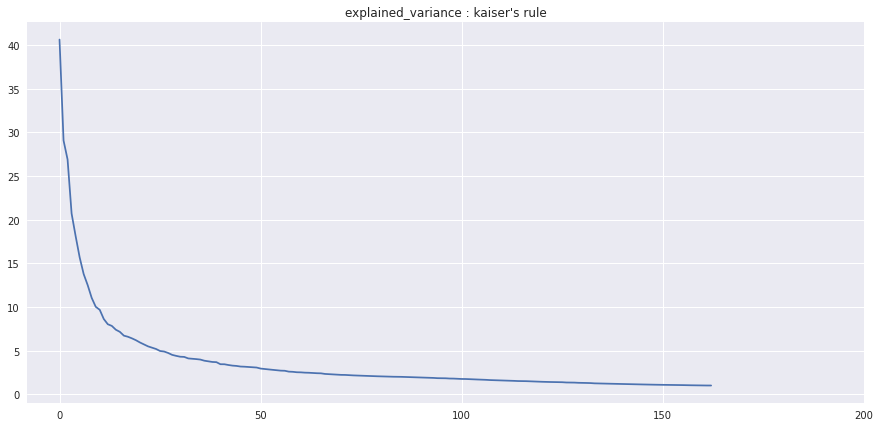

In [16]:
plt.figure(figsize = (15, 7))
plt.plot(kaiser_rule)
plt.xticks([50 * i for i in range(0, 5)])
plt.title("explained_variance : kaiser's rule")

kaiser's rule에 따라 163개의 주성분이 선택됨

#### 누적설명률

In [17]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
ratio_70 = len(cumsum[cumsum < 0.7])
ratio_80 = len(cumsum[cumsum < 0.8])

누적설명량 0.7 : 96
누적설명량 0.8 : 146


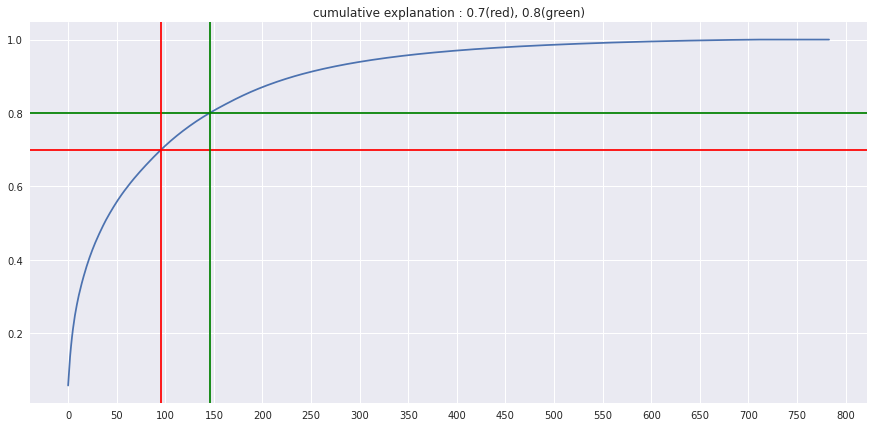

In [18]:
plt.figure(figsize = (15, 7))
plt.plot(cumsum)
plt.axhline(0.7, color = 'r')
plt.axhline(0.8, color = 'g')
plt.axvline(ratio_70, color = 'r')
plt.axvline(ratio_80, color = 'g')
plt.xticks([50 * i for i in range(0, 17)])
plt.title("cumulative explanation : 0.7(red), 0.8(green)")

print("누적설명량 0.7 :", ratio_70)
print("누적설명량 0.8 :", ratio_80)

누적설명량이 0.7 일때는 96개, 0.8 일대는 146개의 주성분이 선택됨

LDA

In [19]:
# https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html

# 위의 참조에 따르면 lda의 n_components <= min(n_classes-1, n_features)이다. 따라서 n_components를 n_classes-1인 9로 채택

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components = 9)
lda.fit(train_data, label)

LinearDiscriminantAnalysis(n_components=9, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [20]:
lda_train_data = lda.transform(train_data)
print(lda_train_data)
print(lda_train_data.shape)

[[ 0.39160973  0.61340051 -1.2170391  ... -0.27875719 -0.30737102
   2.02230184]
 [ 2.39280227 -1.25387406 -0.47253097 ...  0.14314208  1.01159397
  -0.0330026 ]
 [ 0.76924724  3.8030278   0.17449364 ...  0.1027726   0.65762228
  -0.29729475]
 ...
 [ 1.80447053 -0.50483238  0.79975701 ...  0.28430983  0.34988508
  -1.38725928]
 [-6.66479759 -3.37790864 -3.25428579 ...  0.77706597 -2.24822965
   2.14073126]
 [-0.39586311  0.45266327  0.52216537 ...  0.60664075  0.47558794
   0.26250209]]
(56000, 9)


In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X_train, X_val, y_train, y_val = train_test_split(lda_train_data, label, test_size = 0.3)
lr = LogisticRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_val)
print("accuracy :", accuracy_score(y_val, pred))

accuracy : 0.8910119047619047


#### 약 15개 ~ 165개의 주성분 수 중 비교적 간단한 선형모델(logistic regression)의 결과로 최종 주성분 수를 채택

In [22]:
pca = PCA(n_components = 165)
pca_train_data = pca.fit_transform(train_data)

In [23]:
X_train, X_val, y_train, y_val = train_test_split(pca_train_data, label, test_size = 0.3)

In [22]:
accuracy_list = []
for n_component in tqdm(range(15, 166, 5)):

  tmp_train = X_train[:, :n_component]
  tmp_val = X_val[:, :n_component]

  lr = LogisticRegression()
  lr.fit(tmp_train, y_train)
  pred = lr.predict(tmp_val)

  accuracy = accuracy_score(y_val, pred)
  accuracy_list.append(accuracy)

100%|██████████| 31/31 [03:35<00:00,  6.95s/it]


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


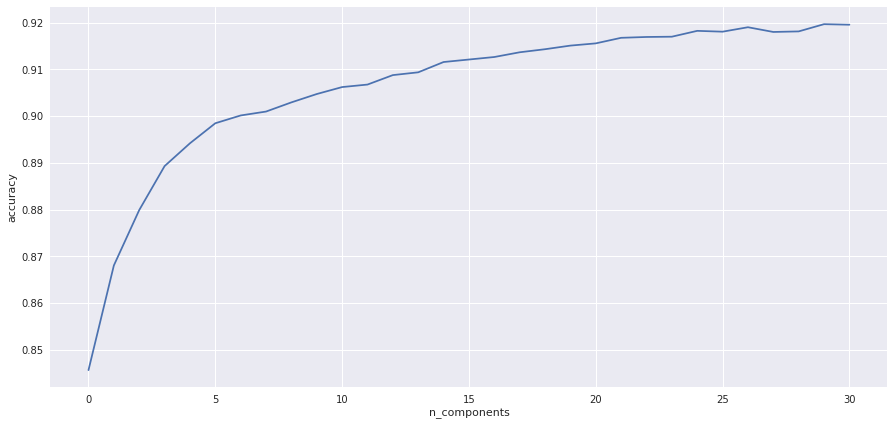

In [30]:
plt.figure(figsize = (15, 7))
plt.plot(accuracy_list)
plt.ylabel("accuracy")
plt.xlabel("n_components")
plt.show()

lda와 pca의 n_components를 달리하여 LogisticRegression 모델을 통한 성능을 확인했다.
전반적으로 n_components의 수가 커질수록 좋은 성능을 보이고있으므로 최종적으로 165개의 주성분 채택

# 3) Modeling

test_data는 검증과정에서 제외

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

In [42]:
pca = PCA(n_components = 165)
train_data_pca = pca.fit_transform(train_data)
test_data_pca = pca.transform(test_data)

#### hyper parameter tuning

In [24]:
!pip install bayesian_optimization
from bayes_opt import BayesianOptimization
from sklearn.model_selection import GridSearchCV

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp37-none-any.whl size=11687 sha256=fcca705e061af9c0f7c261f9c4e1246ab1f00beed6934393c58e85120272e39f
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization


In [25]:
kfold = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 317)

LogisticRegression

In [78]:
def lr_cv(C):
  acc = cross_val_score(LogisticRegression(C = C, random_state = 317),
                        train_data_pca, label, scoring = 'accuracy', cv = kfold).mean()
  return acc

p_bounds = {'C' : (0, 10)}
lr_bo = BayesianOptimization(f = lr_cv, pbounds = p_bounds, verbose = 2)
lr_bo.maximize(init_points = 5, n_iter = 5)

print(lr_bo.max)

|   iter    |  target   |     C     |
-------------------------------------
|  1        |  0.9196   |  1.268    |
|  2        |  0.9195   |  7.594    |
|  3        |  0.9152   |  0.003416 |
|  4        |  0.9196   |  2.87     |
|  5        |  0.9195   |  4.538    |
|  6        |  0.9196   |  9.996    |
|  7        |  0.9195   |  9.999    |
|  8        |  0.9194   |  10.0     |
|  9        |  0.9195   |  9.998    |
|  10       |  0.9195   |  9.999    |
{'target': 0.9196428236088673, 'params': {'C': 9.996182283759545}}


In [30]:
lr = LogisticRegression(C = 9.996, random_state = 317)

RandomForest

In [138]:
params = {'max_depth' : [20, 30, 40, 50],
          'min_samples_split' : [5, 10],
          'min_samples_leaf' : [5, 10]}
rf = RandomForestClassifier()
grid = GridSearchCV(rf, params, scoring = 'accuracy', n_jobs = -1, cv = kfold, verbose = 2)
grid.fit(train_data_pca, label)
print(grid.best_estimator_)
print(grid.best_score_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 26.4min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 33.5min finished
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
0.932999978592092


In [31]:
rf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                            criterion='gini', max_depth=40, max_features='auto',
                            max_leaf_nodes=None, max_samples=None,
                            min_impurity_decrease=0.0, min_impurity_split=None,
                            min_samples_leaf=5, min_samples_split=5,
                            min_weight_fraction_leaf=0.0, n_estimators=100,
                            n_jobs=None, oob_score=False, random_state=None,
                            verbose=0, warm_start=False)

ExtraTree

In [129]:
def et_cv(max_depth, min_samples_split, max_features):
  acc = cross_val_score(ExtraTreesClassifier(n_estimators = 100,
                                            max_depth = int(max_depth),
                                            min_samples_split = int(min_samples_split),
                                            max_features = max_features,
                                            random_state = 317),
                         train_data_pca, label, scoring = 'accuracy', cv = kfold).mean()
  return acc

p_bounds = {'max_depth' : (20, 50),
            'min_samples_split' : (2, 15),
            'max_features' : (0.5, 1)}
et_bo = BayesianOptimization(f = et_cv,  pbounds = p_bounds, verbose = 2)
et_bo.maximize(init_points = 5, n_iter = 10)

et_bo.max

|   iter    |  target   | max_depth | max_fe... | min_sa... |
-------------------------------------------------------------
|  1        |  0.9454   |  42.74    |  0.6622   |  9.917    |
|  2        |  0.9438   |  44.43    |  0.8999   |  13.8     |
|  3        |  0.9478   |  43.05    |  0.8541   |  3.843    |
|  4        |  0.9435   |  25.41    |  0.5773   |  14.74    |
|  5        |  0.9439   |  38.25    |  0.9218   |  12.25    |
|  6        |  0.9472   |  20.1     |  0.7979   |  2.139    |
|  7        |  0.9477   |  49.98    |  0.76     |  2.052    |
|  8        |  0.9486   |  49.62    |  0.6226   |  2.06     |
|  9        |  0.9477   |  49.72    |  0.9908   |  2.014    |
|  10       |  0.9473   |  20.35    |  0.7584   |  2.032    |
|  11       |  0.9487   |  49.76    |  0.8391   |  2.07     |
|  12       |  0.9481   |  49.27    |  0.5168   |  2.047    |
|  13       |  0.9475   |  49.99    |  0.9368   |  2.05     |
|  14       |  0.9489   |  49.74    |  0.547    |  2.0      |
|  15   

{'params': {'max_depth': 49.74449265497426,
  'max_features': 0.5469576475761591,
  'min_samples_split': 2.0002204887426114},
 'target': 0.9488749677601865}

In [32]:
et = ExtraTreesClassifier(n_estimators = 100, max_depth = 50, min_samples_split = 2, max_features = 0.547, random_state = 317)

lgb

In [29]:
def lgb_cv(num_leaves, max_depth, learning_rate, min_split_gain, min_child_weight, min_child_samples, subsample, colsample_bytree, reg_alpha, reg_lambda):
  
  X_train, X_val, y_train, y_val = train_test_split(train_data_pca, label, test_size = 0.2, stratify = label, random_state = 317)
  clf = lgb.LGBMClassifier(num_leaves = int(num_leaves),
                           max_depth = int(max_depth),
                           learning_rate = learning_rate,
                           min_split_gain = min_split_gain,
                           min_child_weight = min_child_weight,
                           min_child_samples = int(min_child_samples),
                           subsample = subsample,
                           colsample_bytree = colsample_bytree,
                           reg_alpha = reg_alpha,
                           reg_lambda = reg_lambda,
                           boosting_type = 'gbdt',
                           n_estimators = 100000,
                           objective = 'multiclass',
                           random_state = 317 )
    
  clf.fit(X_train, y_train, eval_set = [(X_val, y_val)], early_stopping_rounds = 200, verbose = False, eval_metric = 'multi_logloss')

  y_val_pred = clf.predict(X_val)
  acc = accuracy_score(y_val, y_val_pred)
  return acc

p_bounds = {'num_leaves' : (10, 300),
            'max_depth' : (1, 10),
            'learning_rate' : (0.005, 0.1),
            'min_split_gain' : (0, 1),
            'min_child_weight' : (0, 1),
            'min_child_samples' : (10, 30),
            'subsample' : (0.5, 1),
            'colsample_bytree' : (0.5, 1),
            'reg_alpha' : (0, 1),
            'reg_lambda' : (0, 1)}
lgb_bo = BayesianOptimization(f = lgb_cv,  pbounds = p_bounds, verbose = 2)
lgb_bo.maximize(init_points = 5, n_iter = 10)

lgb_bo.max

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.9581   |  0.9279   |  0.07636  |  2.512    |  14.84    |  0.5366   |  0.2535   |  36.68    |  0.1057   |  0.3075   |  0.6563   |
|  2        |  0.9566   |  0.5879   |  0.0396   |  3.625    |  22.19    |  0.7706   |  0.7208   |  103.2    |  0.2954   |  0.003239 |  0.7517   |
|  3        |  0.9547   |  0.892    |  0.06415  |  7.688    |  16.7     |  0.9416   |  0.6549   |  47.4     |  0.1425   |  0.6975   |  0.6543   |
|  4        |  0.9564   |  0.6624   |  0.07431  |  7.586    |  13.93    |  0.09595  |  0.4997   |  111.3    |  0.2624   |  0.2752   |  0.9657   |
|  5        |  0.9613   |  0.8263   |  0.07493  |  5.55     |  27.77    |  0.9927   |  0.2007   |  52.18    |  0.3206   |  0

{'params': {'colsample_bytree': 0.8263148772820653,
  'learning_rate': 0.0749278660011361,
  'max_depth': 5.550020507204222,
  'min_child_samples': 27.770034167201462,
  'min_child_weight': 0.9927472827860022,
  'min_split_gain': 0.20067898728477263,
  'num_leaves': 52.17772056144136,
  'reg_alpha': 0.3205905486317797,
  'reg_lambda': 0.579342396453813,
  'subsample': 0.8049833598121661},
 'target': 0.9613392857142857}

In [33]:
lgbclf = lgb.LGBMClassifier(num_leaves = 52,
                            max_depth = 5,
                            learning_rate = 0.0749278660011361,
                            min_split_gain = 0.20067898728477263,
                            min_child_weight = 0.9927472827860022,
                            min_child_samples = 27,
                            subsample = 0.8049833598121661,
                            colsample_bytree = 0.8263148772820653,
                            reg_alpha = 0.3205905486317797,
                            reg_lambda = 0.579342396453813,
                            boosting_type = 'gbdt',
                            n_estimators = 100000,
                            objective = 'multiclass',
                            random_state = 317 )

원래 데이터와 시간 및 성능 비교

In [51]:
import time

In [48]:
a = time.time()
lr.fit(train_data, label)
b = time.time()
lr_pred = lr.predict(test_data)
print("pca 전 logisticregression")
print("acc :", accuracy_score(y_test, lr_pred), "시간 :", b-a)

pca 전 logisticregression
acc : 0.9210714285714285 시간 : 38.10466742515564


In [50]:
a = time.time()
lr.fit(train_data_pca, label)
b = time.time()
lr_pred = lr.predict(test_data_pca)
print("pca 후 logisticregression")
print("acc :", accuracy_score(y_test, lr_pred), "시간 :", b-a)

pca 후 logisticregression
acc : 0.9162857142857143 시간 : 11.158262491226196


In [55]:
a = time.time()
rf.fit(train_data, label)
b = time.time()
rf_pred = rf.predict(test_data)
print("pca 전 randomforest")
print("acc :", accuracy_score(y_test, rf_pred), "시간 :", b-a)

pca 전 randomforest
acc : 0.964 시간 : 36.247549057006836


In [56]:
a = time.time()
rf.fit(train_data_pca, label)
b = time.time()
rf_pred = rf.predict(test_data_pca)
print("pca 후 randomforest")
print("acc :", accuracy_score(y_test, rf_pred), "시간 :", b-a)

pca 후 randomforest
acc : 0.9415714285714286 시간 : 96.50296092033386


In [57]:
a = time.time()
et.fit(train_data, label)
b = time.time()
et_pred = et.predict(test_data)
print("pca 전 extratrees")
print("acc :", accuracy_score(y_test, et_pred), "시간 :", b-a)

pca 전 extratrees
acc : 0.9747142857142858 시간 : 351.89229464530945


In [58]:
a = time.time()
et.fit(train_data_pca, label)
b = time.time()
et_pred = et.predict(test_data_pca)
print("pca 후 extratrees")
print("acc :", accuracy_score(y_test, et_pred), "시간 :", b-a)

pca 후 extratrees
acc : 0.9570714285714286 시간 : 83.76530170440674


In [59]:
X_train, X_val, y_train, y_val = train_test_split(train_data, label, test_size = 0.2, stratify = label, random_state = 317)
a = time.time()
lgbclf.fit(X_train, y_train, eval_set = [(X_val, y_val)], early_stopping_rounds = 200, verbose = False, eval_metric = 'multi_logloss')
b = time.time()
lgb_pred = lgbclf.predict(test_data)
print("pca 전 lgb")
print("acc :", accuracy_score(y_test, lgb_pred), "시간 :", b-a)

pca 전 lgb
acc : 0.9730714285714286 시간 : 338.4226334095001


In [61]:
X_train, X_val, y_train, y_val = train_test_split(train_data_pca, label, test_size = 0.2, stratify = label, random_state = 317)
a = time.time()
lgbclf.fit(X_train, y_train, eval_set = [(X_val, y_val)], early_stopping_rounds = 200, verbose = False, eval_metric = 'multi_logloss')
b = time.time()
lgb_pred = lgbclf.predict(test_data_pca)
print("pca 후 lgb")
print("acc :", accuracy_score(y_test, lgb_pred), "시간 :", b-a)

pca 후 lgb
acc : 0.9628571428571429 시간 : 198.87552952766418


#### Ensemble


In [83]:
def accuracy_by_cv(clf, train, label):
  cv_train = np.zeros(shape = (train.shape[0], 10))

  kfold = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 317)
  for train_idx, val_idx in kfold.split(train, label):
    X_train, X_val = train[train_idx], train[val_idx]
    y_train, y_val = label.iloc[train_idx], label.iloc[val_idx]

    if type(clf).__name__ in ['ExtraTreesClassifier', 'RandomForestClassifier', 'LogisticRegression']:
      clf.fit(X_train, y_train)
      pred = clf.predict_proba(X_val)
    else:
      clf.fit(X_train, y_train, eval_set = [(X_val, y_val)], early_stopping_rounds = 200, verbose = False, eval_metric = 'multi_logloss')
      pred = clf.predict_proba(X_val)

    cv_train[val_idx] = pred

  return cv_train

In [76]:
cv_lr = accuracy_by_cv(lr, train_data_pca, label)

In [79]:
cv_rf = accuracy_by_cv(rf, train_data_pca, label)

In [84]:
cv_et = accuracy_by_cv(et, train_data_pca, label)

In [90]:
cv_lgb = accuracy_by_cv(lgbclf, train_data_pca, label)

In [106]:
clfs = {'lr' : cv_rf, 'rf' : cv_rf, 'et' : cv_et, 'lgb' : cv_lgb}

In [119]:
from itertools import combinations

max_combi = 0
max_acc = 0
for i in range(2, 5):
  for c in combinations(clfs, i):

    final_pred = np.zeros(train_data_pca.shape[0])
    mean = np.zeros((train_data_pca.shape[0], 10))

    for pred in c:
      mean += clfs[pred]
    mean /= i

    for j in range(len(train_data_pca)):
      final_pred[j] = np.argmax(mean[j])
    
    accuracy = accuracy_score(label, final_pred)

    if accuracy > max_acc:
      max_acc = accuracy
      max_combi = c
print('best score :', max_acc, '\nmodels :', max_combi)

best score : 0.9610535714285714 
models : ('et', 'lgb')


앙상블 검증 결과 extratrees와 lgb모델의 평균이 0.96으로 가장 accuracy가 높았으므로 test data에 적용

In [120]:
X_train, X_val, y_train, y_val = train_test_split(train_data_pca, label, test_size = 0.2, stratify = label, random_state = 317)
et_pred = et.fit(train_data_pca, label).predict_proba(test_data_pca)
lgbclf.fit(X_train, y_train, eval_set = [(X_val, y_val)], early_stopping_rounds = 200, verbose = False, eval_metric = 'multi_logloss')
lgb_pred = lgbclf.predict_proba(test_data_pca)

In [125]:
ensemble_proba = 0.5 * et_pred + 0.5 * lgb_pred
emsemble_pred = np.zeros(test_data_pca.shape[0])
for i in range(len(ensemble_proba)):
  emsemble_pred[i] = np.argmax(ensemble_proba[i])

print("et, lgb ensemble accuracy score :", accuracy_score(y_test, emsemble_pred))

et, lgb ensemble accuracy score : 0.9643571428571428


#### stacking

In [127]:
def stacking_by_cv(clf, train, label, test):

  S_train = np.zeros(shape = (train.shape[0], 10))
  S_test = np.zeros(shape = (test.shape[0], 10))

  kfold = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 317)
  for train_idx, val_idx in kfold.split(train, label):
    X_train, X_val = train[train_idx], train[val_idx]
    y_train, y_val = label.iloc[train_idx], label.iloc[val_idx]

    if type(clf).__name__ in ['ExtraTreesClassifier', 'RandomForestClassifier', 'LogisticRegression']:
      clf.fit(X_train, y_train)
      pred = clf.predict_proba(X_val)
      test_pred = clf.predict_proba(test)

    else:
      clf.fit(X_train, y_train, eval_set = [(X_val, y_val)], early_stopping_rounds = 200, verbose = False, eval_metric = 'multi_logloss')
      pred = clf.predict_proba(X_val)
      test_pred = clf.predict_proba(test)

    S_train[val_idx] = pred
    S_test += test_pred / 4
    
  return S_train, S_test

In [133]:
lr_train, lr_test = stacking_by_cv(lr, train_data_pca, label, test_data_pca)

In [135]:
rf_train, rf_test = stacking_by_cv(rf, train_data_pca, label, test_data_pca)

In [136]:
et_train, et_test = stacking_by_cv(et, train_data_pca, label, test_data_pca)

In [137]:
lgb_train, lgb_test = stacking_by_cv(lgbclf, train_data_pca, label, test_data_pca)

In [141]:
S_train = pd.concat([pd.DataFrame(lr_train), pd.DataFrame(rf_train), pd.DataFrame(et_train), pd.DataFrame(lgb_train)], axis = 1)
S_test = pd.concat([pd.DataFrame(lr_test), pd.DataFrame(rf_test), pd.DataFrame(et_test), pd.DataFrame(lgb_test)], axis = 1)
S_train.columns = [str(i) for i in range(40)]
S_test.columns = [str(i) for i in range(40)]

In [146]:
def lgb_cv(num_leaves, max_depth, learning_rate, min_split_gain, min_child_weight, min_child_samples, subsample, colsample_bytree, reg_alpha, reg_lambda):
  
  X_train, X_val, y_train, y_val = train_test_split(S_train, label, test_size = 0.2, stratify = label, random_state = 317)
  clf = lgb.LGBMClassifier(num_leaves = int(num_leaves),
                           max_depth = int(max_depth),
                           learning_rate = learning_rate,
                           min_split_gain = min_split_gain,
                           min_child_weight = min_child_weight,
                           min_child_samples = int(min_child_samples),
                           subsample = subsample,
                           colsample_bytree = colsample_bytree,
                           reg_alpha = reg_alpha,
                           reg_lambda = reg_lambda,
                           boosting_type = 'gbdt',
                           n_estimators = 100000,
                           objective = 'multiclass',
                           random_state = 317 )
    
  clf.fit(X_train, y_train, eval_set = [(X_val, y_val)], early_stopping_rounds = 100, verbose = False, eval_metric = 'multi_logloss')

  y_val_pred = clf.predict(X_val)
  acc = accuracy_score(y_val, y_val_pred)
  return acc

p_bounds = {'num_leaves' : (10, 300),
            'max_depth' : (1, 10),
            'learning_rate' : (0.05, 0.1),
            'min_split_gain' : (0, 1),
            'min_child_weight' : (0, 1),
            'min_child_samples' : (10, 30),
            'subsample' : (0.5, 1),
            'colsample_bytree' : (0.5, 1),
            'reg_alpha' : (0, 1),
            'reg_lambda' : (0, 1)}
lgb_bo = BayesianOptimization(f = lgb_cv,  pbounds = p_bounds, verbose = 2)
lgb_bo.maximize(init_points = 5, n_iter = 5)

lgb_bo.max

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.9674   |  0.9783   |  0.09069  |  8.046    |  21.2     |  0.7701   |  0.3641   |  89.03    |  0.9414   |  0.3095   |  0.9705   |
|  2        |  0.9678   |  0.7701   |  0.09822  |  9.662    |  11.27    |  0.08232  |  0.4068   |  148.9    |  0.7786   |  0.5958   |  0.9414   |
|  3        |  0.9678   |  0.8746   |  0.05001  |  9.29     |  15.71    |  0.5199   |  0.132    |  54.62    |  0.9698   |  0.05784  |  0.853    |
|  4        |  0.9679   |  0.6808   |  0.08977  |  2.032    |  14.26    |  0.8183   |  0.6975   |  115.5    |  0.2498   |  0.9475   |  0.5999   |
|  5        |  0.9668   |  0.6345   |  0.09811  |  1.968    |  26.6     |  0.5264   |  0.1284   |  63.11    |  0.9437   |  0

{'params': {'colsample_bytree': 0.8874096275616024,
  'learning_rate': 0.05289806249547255,
  'max_depth': 2.1600518140820175,
  'min_child_samples': 10.570248739333831,
  'min_child_weight': 0.28203204056643927,
  'min_split_gain': 0.346143741931107,
  'num_leaves': 299.9125433838585,
  'reg_alpha': 0.4030801242885661,
  'reg_lambda': 0.8069630451146375,
  'subsample': 0.9340640675970662},
 'target': 0.96875}

In [147]:
lgbclf = lgb.LGBMClassifier(num_leaves = 299,
                            max_depth = 2,
                            learning_rate = 0.05289806249547255,
                            min_split_gain = 0.346143741931107,
                            min_child_weight = 0.28203204056643927,
                            min_child_samples = 10,
                            subsample =  0.9340640675970662,
                            colsample_bytree = 0.8874096275616024,
                            reg_alpha = 0.4030801242885661,
                            reg_lambda = 0.8069630451146375,
                            boosting_type = 'gbdt',
                            n_estimators = 100000,
                            objective = 'multiclass',
                            random_state = 317 )

In [148]:
X_train, X_val, y_train, y_val = train_test_split(S_train, label, test_size = 0.2, stratify = label)
lgbclf.fit(X_train, y_train, eval_set = [(X_val, y_val)], early_stopping_rounds = 100, verbose = False, eval_metric = 'multi_logloss')
pred = lgbclf.predict(S_test)
print("stacking accuracy score :", accuracy_score(y_test, pred))

stacking accuracy score : 0.9697142857142858


- pca 전

logisticregression 
acc : 0.9210714285714285 시간 : 38.10466742515564

randomforest
acc : 0.964 시간 : 36.247549057006836

extratrees
acc : 0.9747142857142858 시간 : 351.89229464530945

lgb
acc : 0.9730714285714286 시간 : 338.4226334095001

- pca 후

logisticregression 
acc : 0.9162857142857143 시간 : 11.158262491226196

randomforest
acc : 0.9415714285714286 시간 : 96.50296092033386

extratrees
acc : 0.9570714285714286 시간 : 83.76530170440674

lgb
acc : 0.9628571428571429 시간 : 198.87552952766418

- 앙상블

extratrees, lgb 사용 시 acc : 0.9610535714285714 

- 스태킹

0.9697142857142858

pca 전 후 비교 결과 단일모델의 성능에서 pca 후의 성능이 대체로 훨씬 좋았음. 아무래도 pca는 표현량을 줄이기 때문이라고 판단됨
시간측면에서는 훨씬 이득이 있었음

모델링 결과 스태킹하여 최종 lgb로 예측성능이 0.9697로 가장 좋았음